---
# title: "My Notebook"
format:
  html:
    toc: true           # ✅ Table of contents (outline)
    toc-location: left  # ✅ Place TOC in the left sidebar
    number-sections: true
    code-fold: true
    code-summary: "Show Code"
    theme: cosmo        # Optional themes: cosmo, flatly, default, etc.
---

# Week 5B: Raster Data Analysis
- Sep 25, 2025

In [33]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd

In [34]:
np.seterr("ignore")

{'divide': 'ignore', 'over': 'ignore', 'under': 'ignore', 'invalid': 'ignore'}

**Raster data analysis with the holoviz ecosystem**

Two case studies:

- Using satellite imagery to detect changes in lake volume
- Detecting urban heat islands in Philadelphia

## The decline of the world's saline lakes

- A 2017 study that looked at the volume decline of many of the world's saline lakes
- Primarily due to water diversion and climate change
- Estimate the amount of inflow required to sustain these ecosystems

Some examples...

## The Aral Sea in Kazakhstan

### 2000

<img src="imgs/aral-1.jpeg" width=700></img>

### 2018
<img src="imgs/aral-2.jpeg" width=700></img>

Source: [https://earthobservatory.nasa.gov/world-of-change/AralSea](https://earthobservatory.nasa.gov/world-of-change/AralSea)

## Lake Urmia in Iran

### 1998
<img src="imgs/urmia-1.jpeg" width=700></img>

### 2011
<img src="imgs/urmia-2.jpeg" width=700></img>

Source: [https://earthobservatory.nasa.gov/images/76327/lake-orumiyeh-iran](https://earthobservatory.nasa.gov/images/76327/lake-orumiyeh-iran)

## Today: Walker Lake

### 1988

<img src="imgs/walker-1.jpeg" width=700></img>

### 2017

<img src="imgs/walker-2.jpeg" width=700><img>

Source: [https://earthobservatory.nasa.gov/images/91921/disappearing-walker-lake](https://earthobservatory.nasa.gov/images/91921/disappearing-walker-lake)

### Let's analyze this in Python!

In [35]:
# import intake
import xarray as xr

# hvplot
import hvplot.xarray
import hvplot.pandas

In [36]:
import holoviews as hv
import geoviews as gv
from geoviews.tile_sources import EsriImagery

### First, let's use intake to load the data

Catalog file: [https://github.com/pyviz-topics/EarthML/blob/master/examples/catalog.yml](https://github.com/pyviz-topics/EarthML/blob/master/examples/catalog.yml)

Source: [EarthML](http://earthml.pyviz.org/)

In [37]:
# url = 'https://raw.githubusercontent.com/pyviz-topics/EarthML/master/examples/catalog.yml'
# cat = intake.open_catalog(url)

In [38]:
# list(cat)

We'll focus on the Landsat 5 and 8 small datasets.

These are "small" snapshots around Walker Lake, around cut out of the larger Landsat dataset.

### Download the Landsat 5 imagery

Here we download the data from the AWS, we will talk more about this in future when we talk about the web scrabing. 

In [39]:
import requests
import rasterio
import os

# Scene info
base_url = "https://earth-data.s3.amazonaws.com/landsat/small"
scene_id = "LT05_L1TP_042033_19881022_20161001_01_T1"
bands = range(1, 8)   # Landsat 5 TM has 7 bands

# Make output folder
os.makedirs("landsat_bands", exist_ok=True)
local_files = []

# --- Download each band ---
for b in bands:
    url = f"{base_url}/{scene_id}_sr_band{b}.tif"
    local_path = f"landsat_bands/band{b}.tif"
    print(f"Downloading {url}")
    r = requests.get(url, stream=True)
    if r.status_code == 200:
        with open(local_path, "wb") as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)
        local_files.append(local_path)
    else:
        print(f"⚠️ Failed to download {url} (status {r.status_code})")


# --- Stack into one multiband GeoTIFF ---
if local_files:
    # Copy metadata from the first band
    with rasterio.open(local_files[0]) as src0:
        meta = src0.meta.copy()
    
    meta.update(count=len(local_files))

    stack_path = f"{scene_id}_stack.tif"
    with rasterio.open(stack_path, "w", **meta) as dst:
        for idx, file in enumerate(local_files, start=1):
            with rasterio.open(file) as src:
                dst.write(src.read(1), idx)

    print(f"✅ Stacked file written to {stack_path}")
else:
    print("❌ No bands downloaded, nothing to stack.")

⚠️ Failed to download https://earth-data.s3.amazonaws.com/landsat/small/LT05_L1TP_042033_19881022_20161001_01_T1_sr_band6.tif (status 404)
✅ Stacked file written to LT05_L1TP_042033_19881022_20161001_01_T1_stack.tif


### Download landsat 7 satellite imagery


In [40]:
import requests
import rasterio
import os

# Scene info (note: path changed to HTTPS instead of s3://)
base_url = "https://earth-data.s3.amazonaws.com/landsat/small"
scene_id = "LC08_L1TP_042033_20171022_20171107_01_T1"  # Landsat 7/8 ID
bands = range(1, 8)   # typically bands 1–7 (surface reflectance)

# Make output folder
os.makedirs("landsat7_bands", exist_ok=True)
local_files = []

# --- Download each band ---
for b in bands:
    url = f"{base_url}/{scene_id}_sr_band{b}.tif"
    local_path = f"landsat7_bands/band{b}.tif"
    print(f"Downloading {url}")
    r = requests.get(url, stream=True)
    if r.status_code == 200:
        with open(local_path, "wb") as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)
        local_files.append(local_path)
    else:
        print(f"⚠️ Failed to download {url} (status {r.status_code})")

# --- Stack into one multiband GeoTIFF ---
if local_files:
    # Copy metadata from first band
    with rasterio.open(local_files[0]) as src0:
        meta = src0.meta.copy()

    meta.update(count=len(local_files))

    stack_path = f"{scene_id}_stack.tif"
    with rasterio.open(stack_path, "w", **meta) as dst:
        for idx, file in enumerate(local_files, start=1):
            with rasterio.open(file) as src:
                dst.write(src.read(1), idx)

    print(f"✅ Stacked file written to {stack_path}")
else:
    print("❌ No bands downloaded, nothing to stack.")

✅ Stacked file written to LC08_L1TP_042033_20171022_20171107_01_T1_stack.tif


### We can use dask to read the data

This will return an `xarray` `DataArray` where the values are stored as `dask` arrays.

In [9]:
# !pip install dask
# !pip install --upgrade dask

In [41]:
import rioxarray as rxr

# Read Landsat 5 (stacked multiband GeoTIFF you created earlier)
landsat_5_da = rxr.open_rasterio("LT05_L1TP_042033_19881022_20161001_01_T1_stack.tif", 
                             masked=True, 
                            #  chunks=True   # 👈 ensures it's backed by dask
                            )

print(landsat_5_da)          # DataArray, dims: (band, y, x)
print(type(landsat_5_da.data))  # should be <class 'dask.array.core.Array'>


# Read Landsat 8
landsat_8_da = rxr.open_rasterio("LC08_L1TP_042033_20171022_20171107_01_T1_stack.tif", 
                             masked=True, 
                            #  chunks=True   # 👈 ensures it's backed by dask
                            )


<xarray.DataArray (band: 6, y: 300, x: 300)> Size: 4MB
[540000 values with dtype=float64]
Coordinates:
  * band         (band) int64 48B 1 2 3 4 5 6
  * x            (x) float64 2kB 3.324e+05 3.326e+05 ... 3.771e+05 3.772e+05
  * y            (y) float64 2kB 4.309e+06 4.309e+06 ... 4.264e+06 4.264e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
<class 'numpy.ndarray'>


### Use ".values" to convert to a numpy array

In [42]:
landsat_5_da.shape

(6, 300, 300)

In [44]:
# landsat_5_da.values

::: {.callout-important}

- EPSG 32611 is the default CRS for Landsat data
- Units are meters

:::

### Evidence of shrinkage?

- We want to compare the images across time.
- Data for Landsat 8 is from 2017
- Data for Landat 5 is from 1988

**Problem:** they appear to cover different areas

### First: Let's plot RGB images of the two datasets

See [lecture 5B](https://musa-550-fall-2023.github.io/content/week-5/lecture-5B.html#part-1-getting-started-with-rasterio) for a reminder! 

**Hints**
- We want to use the `earthpy` package to do the plotting.
- We can use the `data.sel(band=bands)` syntax to select specific bands from the dataset, where bands is a list of the desired bands to be selected.

#### Important notes

* For Landsat 5, the RGB bands are bands 3, 2, and 1, respectively.
* For Landsat 8, the RGB bands are bands 4, 3, and 2, respectively.
* Reference: [Landsat 5](https://www.usgs.gov/land-resources/nli/landsat/landsat-5) and [Landsat 8](https://landsat.gsfc.nasa.gov/landsat-8/landsat-8-bands/)

In [46]:
# !pip install earthpy

In [47]:
import earthpy.plot as ep

#### Landsat 8 color image

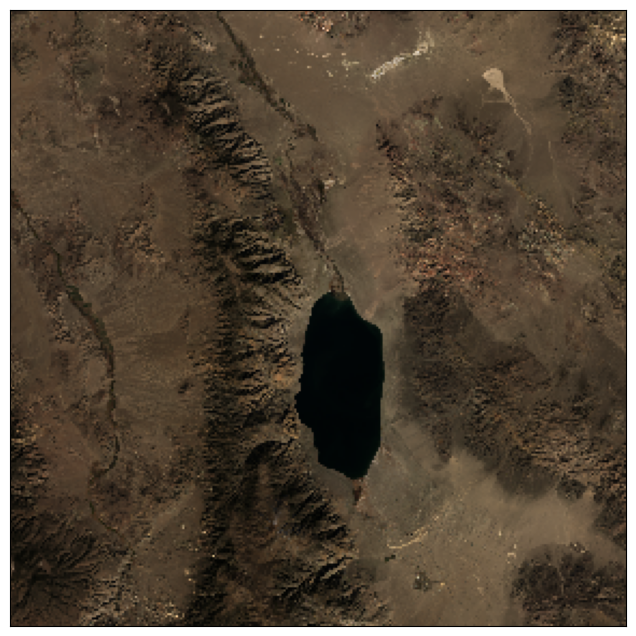

In [49]:
# Get the RGB data from landsat 8 dataset as a numpy array
rgb_data_8 = landsat_8_da.sel(band=[4,3,2]).values

# # Initialize
fig, ax = plt.subplots(figsize=(8,8))

# # Plot the RGB bands
ep.plot_rgb(rgb_data_8, rgb=(0, 1, 2), ax=ax);

#### Landsat 5 color image

<Axes: >

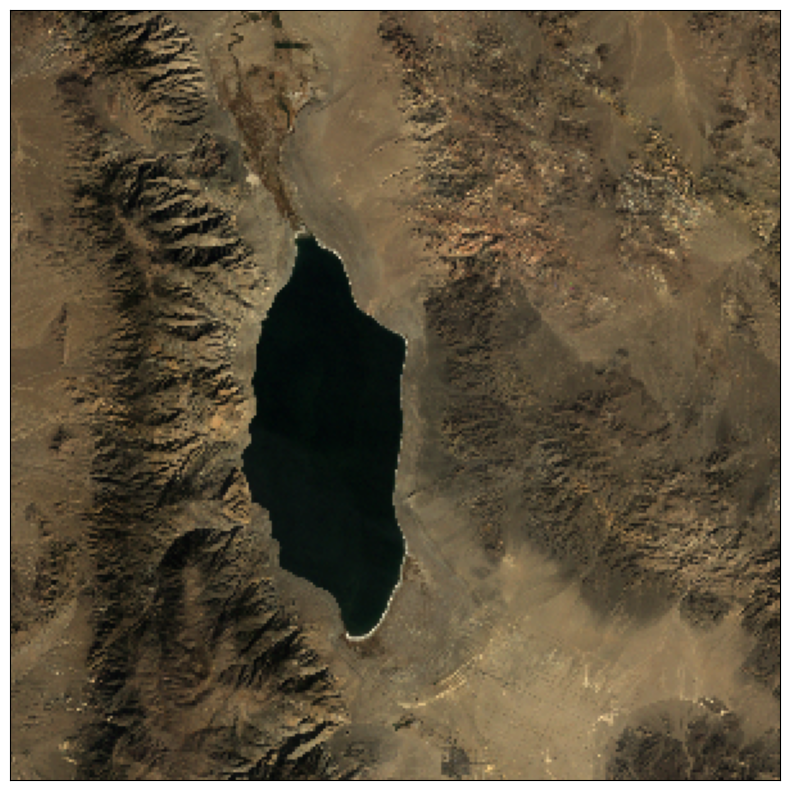

In [50]:
# Get the RGB data from landsat 5 dataset as a numpy array
rgb_data_5 = landsat_5_da.sel(band=[3,2,1]).values

# # Initialize
fig, ax = plt.subplots(figsize=(10,10))

# # Plot the RGB bands
ep.plot_rgb(rgb_data_5, rgb=(0, 1, 2), ax=ax)

### Can we trim these to the same areas?

Yes, we can use xarray builtin selection functionality!

The Landsat 5 images is more zoomed in, so let's trim to the Landsat 8 data to this range

Take advantage of the "coordinate" arrays provided by xarray:

In [51]:
landsat_5_da.x

<xarray.DataArray 'x' (x: 300)> Size: 2kB
array([332400., 332550., 332700., ..., 376950., 377100., 377250.], shape=(300,))
Coordinates:
  * x            (x) float64 2kB 3.324e+05 3.326e+05 ... 3.771e+05 3.772e+05
    spatial_ref  int64 8B 0

In [52]:
landsat_5_da.y

<xarray.DataArray 'y' (y: 300)> Size: 2kB
array([4309200., 4309050., 4308900., ..., 4264650., 4264500., 4264350.],
      shape=(300,))
Coordinates:
  * y            (y) float64 2kB 4.309e+06 4.309e+06 ... 4.264e+06 4.264e+06
    spatial_ref  int64 8B 0

**Remember**: These coordinates are in units of meters!

Let's get the bounds of the Landsat 5 image:

In [53]:
# x bounds
xmin = landsat_5_da.x.min()
xmax = landsat_5_da.x.max()

# y bounds
ymin = landsat_5_da.y.min()
ymax = landsat_5_da.y.max()

### Slicing with xarray

We can use Python's built-in `slice()` function to slice the data's coordinate arrays and select the subset of the data we want.

More info: [http://xarray.pydata.org/en/stable/indexing.html](http://xarray.pydata.org/en/stable/indexing.html)

### Slicing in Python

- A slice object is used to specify how to slice a sequence. 
- You can specify where to start the slicing, and where to end. You can also specify the step, which allows you to e.g. slice only every other item.

Syntax: `slice(start, end, step)`

More info: [https://www.w3schools.com/python/ref_func_slice.asp](https://www.w3schools.com/python/ref_func_slice.asp)

#### An example

In [18]:
letters = ["a", "b", "c", "d", "e", "f", "g", "h"]

letters[0:5:2]

['a', 'c', 'e']

In [19]:
letters[slice(0, 5, 2)]

['a', 'c', 'e']

### Back to xarray and the Landsat data...

We can use the `.sel()` function to slice our `x` and `y` coordinate arrays!

In [20]:
xmax

<xarray.DataArray 'x' ()> Size: 8B
array(377250.)
Coordinates:
    spatial_ref  int64 8B 0

In [54]:
# slice the x and y coordinates
slice_x = slice(xmin, xmax)
slice_y = slice(ymax, ymin) # IMPORTANT: y coordinate array is in descending order

In [55]:
slice_x

slice(<xarray.DataArray 'x' ()> Size: 8B
array(332400.)
Coordinates:
    spatial_ref  int64 8B 0, <xarray.DataArray 'x' ()> Size: 8B
array(377250.)
Coordinates:
    spatial_ref  int64 8B 0, None)

In [57]:
# Use the .sel() to slice
landsat_8_trimmed = landsat_8_da.sel(x=slice_x, y=slice_y)

::: {.callout-important}
The `y` coordinate is stored in descending order, so the slice should be ordered the same way (from ymax to ymin)
:::

### Let's look at the trimmed data

In [58]:
landsat_8_trimmed.shape

(7, 214, 213)

In [59]:
landsat_8_da.shape

(7, 286, 286)

In [60]:
landsat_8_trimmed

<xarray.DataArray (band: 7, y: 214, x: 213)> Size: 3MB
[319074 values with dtype=float64]
Coordinates:
  * band         (band) int64 56B 1 2 3 4 5 6 7
  * x            (x) float64 2kB 3.326e+05 3.328e+05 ... 3.769e+05 3.771e+05
  * y            (y) float64 2kB 4.309e+06 4.309e+06 ... 4.265e+06 4.264e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

Plot the trimmed Landsat 8 data:

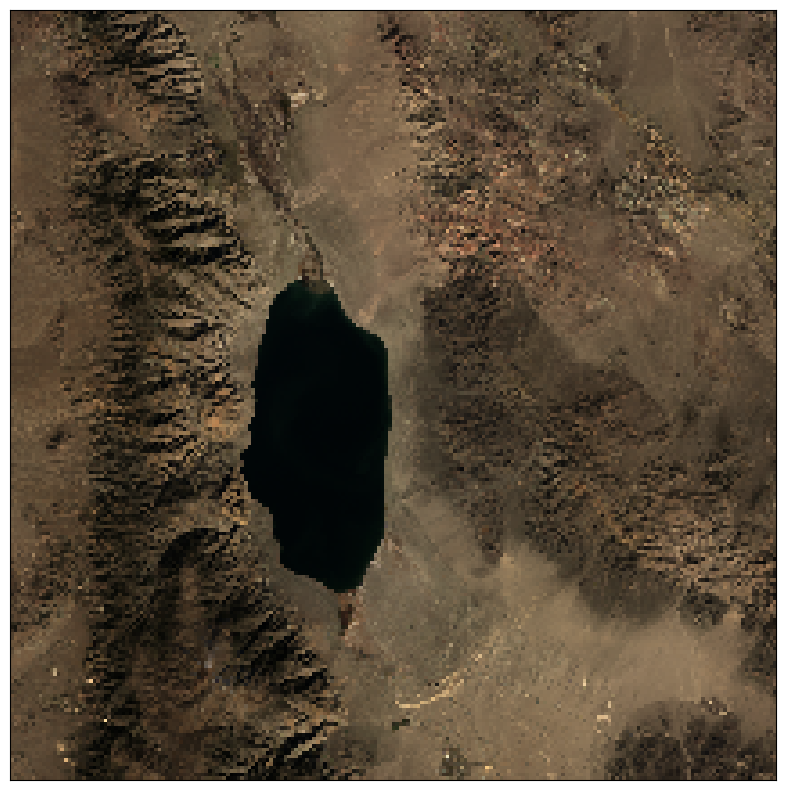

In [61]:
# Get the trimmed landsat 8 RGB data as a numpy array
rgb_data_8 = landsat_8_trimmed.sel(band=[4,3,2]).values

# # Initialize
fig, ax = plt.subplots(figsize=(10,10))

# # Plot the RGB bands
ep.plot_rgb(rgb_data_8, rgb=(0, 1, 2), ax=ax);

Plot the original Landsat 5 data:

<Axes: >

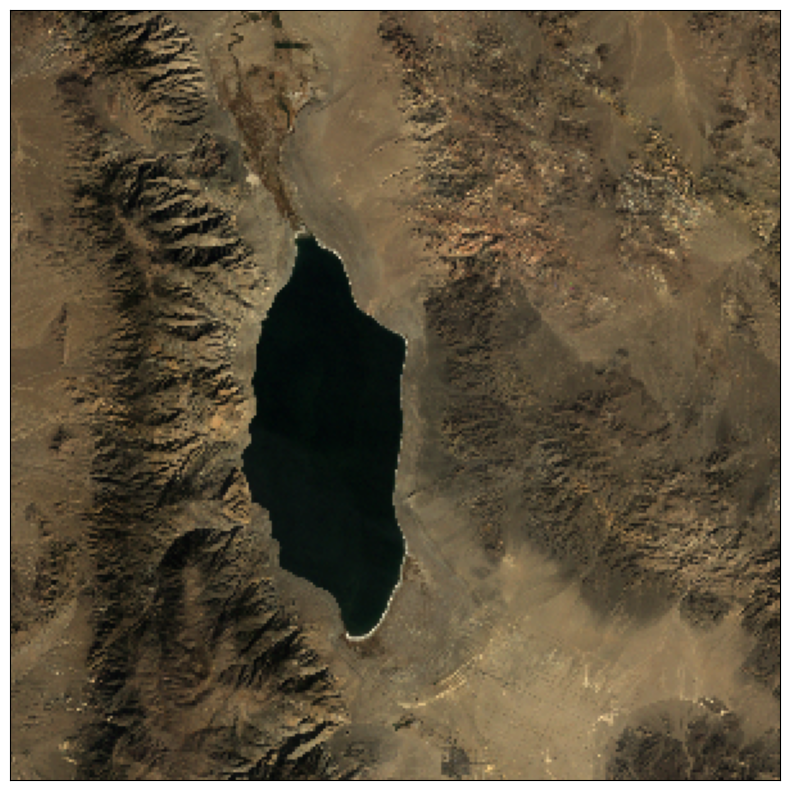

In [62]:
# Select the RGB data as a numpy array
rgb_data_5 = landsat_5_da.sel(band=[3,2,1]).values

# Initialize the figure
fig, ax = plt.subplots(figsize=(10,10))

# Plot the RGB bands
ep.plot_rgb(rgb_data_5, rgb=(0, 1, 2), ax=ax)

Some evidence of shrinkage...but can we do better?

Yes! We'll use the change in the NDVI over time to detect change in lake volume

### Calculate the NDVI for the Landsat 5 (1988) and Landsat 8 (2017) datasets


::: {.callout-note title="Remember"}
- NDVI = (NIR - Red) / (NIR + Red)
- You can once again use the `.sel()` function to select certain bands from the datasets
:::

**For Landsat 5:**
NIR = band 4 and Red = band 3

**For Landsat 8:**
NIR = band 5 and Red = band 4

#### NDVI 1988

In [26]:
NIR_1988 = landsat_5_da.sel(band=4)
RED_1988 = landsat_5_da.sel(band=3)

NDVI_1988 = (NIR_1988 - RED_1988) / (NIR_1988 + RED_1988)

#### NDVI 2017

In [63]:
NIR_2017 = landsat_8_da.sel(band=5)
RED_2017 = landsat_8_da.sel(band=4)

NDVI_2017 = (NIR_2017 - RED_2017) / (NIR_2017 + RED_2017)

#### The difference between 2017 and 1988

- Take the difference between the 2017 NDVI and the 1988 NDVI
- Use the `hvplot.image()` function to show the difference 
- A diverging palette, like `coolwarm`, is particularly useful for this situation

In [64]:
type(NDVI_2017)

xarray.core.dataarray.DataArray

In [65]:
NDVI_1988.shape, NDVI_2017.shape

((300, 300), (286, 286))

xarray automatically aligns them by dimension names and coordinate values, not just by array shape.
- If both have the same dimension names (x, y), xarray tries to align based on the coordinate values (x and y grids).
- If coordinates differ, xarray will broadcast and insert NaN where there’s no match.
- If one has extra dimensions, it will try to expand or broadcast them (like NumPy broadcasting).

So, we can just subtract them directly!

In [66]:
diff = NDVI_2017 - NDVI_1988

diff.hvplot.image(
    x="x",
    y="y",
    frame_height=400,
    frame_width=400,
    cmap="coolwarm",
    clim=(-1, 1),
    geo=True,
    crs=32611,
)

:Image   [x,y]   (value)

In [31]:
diff.shape

(42, 43)

### What's going on here? Why so pixelated?

Two issues:
- Different x/y bounds
- Different resolutions

- NDVI_2017 is a DataArray with dims (y, x) (and maybe band).
- NDVI_2017.x → the 1D array of x-coordinates (eastings/longitudes) of pixel centers.
- NDVI_2017.y → the 1D array of y-coordinates (northings/latitudes) of pixel centers.

In [67]:
# Different x/y ranges!
print(NDVI_1988.x[0].values)
print(NDVI_2017.x[0].values)

332400.0
318300.0


In [68]:
# Different resolutions
print((NDVI_1988.x[1] - NDVI_1988.x[0]).values)
print((NDVI_2017.x[1] - NDVI_2017.x[0]).values)

150.0
210.0


### Use xarray to put the data on the same grid

#### First, calculate a bounding box around the center of the data

In [69]:
# The center lat/lng values in EPSG = 4326
# I got these points from google maps 
x0 = -118.7081
y0 = 38.6942

Let's convert these coordinates to the sames CRS as the Landsat data 

We can also use **geopandas**:

In [70]:
pt = pd.DataFrame({"lng": [x0], "lat": [y0]})

In [71]:
gpt = gpd.GeoDataFrame(
    pt, geometry=gpd.points_from_xy(pt["lng"], pt["lat"]), crs="EPSG:4326"
)

gpt

lng      lat                   geometry
0 -118.7081  38.6942  POINT (-118.7081 38.6942)

Convert to the Landsat CRS. Remember: we are converting from EPSG=4326 to EPSG=32611

In [72]:
pt_32611 = gpt.to_crs(epsg=32611)

Let's add a circle with radius 15 km around the midpoint

In [73]:
pt_32611_buffer = pt_32611.copy()
pt_32611_buffer.geometry = pt_32611.geometry.buffer(15e3)  # Add a 15 km radius buffer

#### Did this work?

Use the builting geoviews imagery to confirm..

In [74]:
EsriImagery * pt_32611_buffer.hvplot(alpha=0.4, geo=True, crs=32611)

:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Polygons.I :Polygons   [Longitude,Latitude]

#### Now, let's set up the grid

In [76]:
res = 200 # 200 meter resolution
x = np.arange(xmin, xmax, res)
y = np.arange(ymin, ymax, res)

In [77]:
len(x)

225

In [78]:
len(y)

225

#### Do the re-gridding

This does a linear interpolation of the data using the nearest pixels.

In [79]:
NDVI_2017_regridded = NDVI_2017.interp(x=x, y=y)
NDVI_1988_regridded = NDVI_1988.interp(x=x, y=y)

#### Plot the re-gridded data side-by-side

In [81]:

import hvplot.xarray  # or hvplot.pandas if using DataFrame
import holoviews as hv
hv.extension("bokeh")   # or "matplotlib", but "bokeh" is better for geo plots


img1988 = NDVI_1988_regridded.hvplot.image(
    x="x",
    y="y",
    crs=32611,
    geo=True,
    frame_height=300,
    frame_width=300,
    clim=(-3, 1),
    cmap="fire",
    title="1988"
)


img2017 = NDVI_2017_regridded.hvplot.image(
    x="x",
    y="y",
    crs=32611,
    geo=True,
    frame_height=300,
    frame_width=300,
    clim=(-3, 1),
    cmap="fire",
    title="2017"
)

img1988 + img2017

:Layout
   .Image.I  :Image   [x,y]   (value)
   .Image.II :Image   [x,y]   (value)

In [82]:
NDVI_2017_regridded.shape, NDVI_1988_regridded.shape

((225, 225), (225, 225))

Now that the images are lined up, **the change in lake volume is clearly apparent**

In [83]:
diff_regridded = NDVI_2017_regridded - NDVI_1988_regridded
diff_regridded

<xarray.DataArray (y: 225, x: 225)> Size: 405kB
array([[ 0.04698485,  0.06277272,  0.04696496, ...,  0.04812127,
        -0.01462977,  0.01676142],
       [ 0.04915427,  0.03146362,  0.02520037, ...,  0.00764362,
         0.02925599,  0.03030879],
       [ 0.05773904,  0.03895859,  0.03848018, ...,  0.04350497,
         0.02471431,  0.03191422],
       ...,
       [ 0.02993016,  0.03760638,  0.03355653, ..., -0.00899765,
         0.0051297 , -0.00335074],
       [ 0.02457032,  0.04594643,  0.03676735, ...,  0.00616795,
        -0.01034597, -0.00197619],
       [ 0.07661604,  0.04792224,  0.04808855, ...,  0.00257181,
        -0.00252524,  0.00854541]], shape=(225, 225))
Coordinates:
    spatial_ref  int64 8B 0
  * x            (x) float64 2kB 3.324e+05 3.326e+05 ... 3.77e+05 3.772e+05
  * y            (y) float64 2kB 4.264e+06 4.265e+06 ... 4.309e+06 4.309e+06

In [84]:
diff_regridded.hvplot.image(
    x="x",
    y="y",
    crs=32611,
    geo=True,
    frame_height=400,
    frame_width=400,
    cmap="coolwarm",
    clim=(-1, 1),
)

:Image   [x,y]   (value)

#### Takeaway:

The red areas (more vegetation in 2017) show clear loss of lake volume

### One more thing: downsampling hi-res data

Given hi-resolution data, we can downsample to a lower resolution with the familiar groupby / mean framework from pandas

Let's try a resolution of 1000 meters instead of 200 meters

In [62]:
# Define a low-resolution grid
res_1000 = 1000
x_1000 = np.arange(xmin, xmax, res_1000)
y_1000 = np.arange(ymin, ymax, res_1000)

In [63]:
x_1000.shape, y_1000.shape

((45,), (45,))

In [64]:
# Groupby new bins and take the mean of all pixels falling into a group
# First: groupby low-resolution x bins and take mean
# Then: groupby low-resolution y bins and take mean
diff_res_1000 = (
    diff_regridded.groupby_bins("x", x_1000, labels=x_1000[:-1])
    .mean(dim="x")
    .groupby_bins("y", y_1000, labels=y_1000[:-1])
    .mean(dim="y")
    .rename(x_bins="x", y_bins="y")
)
diff_res_1000

<xarray.DataArray (y: 44, x: 44)> Size: 15kB
array([[0.04441188, 0.05055985, 0.05840989, ..., 0.03623162, 0.02836244,
        0.0223555 ],
       [0.04569241, 0.04080022, 0.04404605, ..., 0.03685891, 0.02847791,
        0.02341687],
       [0.04603897, 0.03883327, 0.04078481, ..., 0.02513061, 0.02298011,
        0.01997115],
       ...,
       [0.03367364, 0.03217862, 0.0394038 , ..., 0.01064314, 0.01451403,
        0.01129917],
       [0.03634618, 0.03259205, 0.03609488, ..., 0.00979841, 0.01484085,
        0.01514796],
       [0.03707802, 0.03183665, 0.04082304, ..., 0.00811861, 0.00924846,
        0.00649866]])
Coordinates:
    spatial_ref  int64 8B 0
  * x            (x) float64 352B 3.324e+05 3.334e+05 ... 3.744e+05 3.754e+05
  * y            (y) float64 352B 4.264e+06 4.265e+06 ... 4.306e+06 4.307e+06

#### Now let's plot the low-resolution version of the difference

In [65]:
diff_res_1000.hvplot.image(
    x="x",
    y="y",
    crs=32611,
    geo=True,
    frame_width=500,
    frame_height=400,
    cmap="coolwarm",
    clim=(-1, 1),
)

:Image   [x,y]   (value)